In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null, forward_simulation

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'ryan'
category = 'natural'
eccentricity = 'fovea'
movie_id = 5
diameter = 24; # 6, 24, 36
dat_movie_name = 'PRAIRIE'   # movie name as in the data file name
stim_movie_name = 'prairie1' # movie name as in the stimulus file name

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
n_dim = n_frames - 1
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_dim=n_dim, n_starts=10, n_iter=10000, n_frames=n_frames, is_natural=is_natural, version=1, disp=False)

ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 647.6039978265762
Current loss: 642.8114132508636
Loss updated
Iteration 2 | Loss: 642.8114132508636
Current loss: 641.5080608129501
Loss updated
Iteration 3 | Loss: 641.5080608129501
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 4 | Loss: 634.3901415392756
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 5 | Loss: 637.3951376378536
Current loss: 631.7402897104621
Loss updated
Iteration 6 | Loss: 631.7402897104621
Current loss: 649.4554973691702
Iteration 7 | Loss: 649.4554973691702
Current loss: 629.4809183627367
Loss updated
Iteration 8 | Loss: 629.4809183627367
Current loss: 643.4754984304309
Iteration 9 | Loss: 643.4754984304309
Current loss: 646.6606427431107
Iteration 10 | Loss: 646.6606427431107


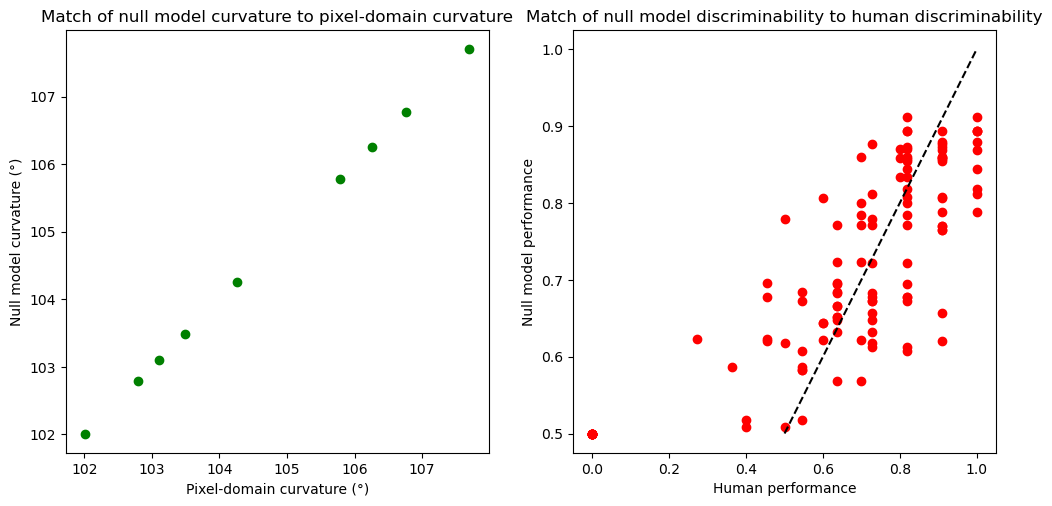

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Human performance')
axs[1].set_ylabel('Null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [6]:
# n_reps = int(np.max(n_total_obs))
n_reps = 10
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.squeeze(), n_reps)

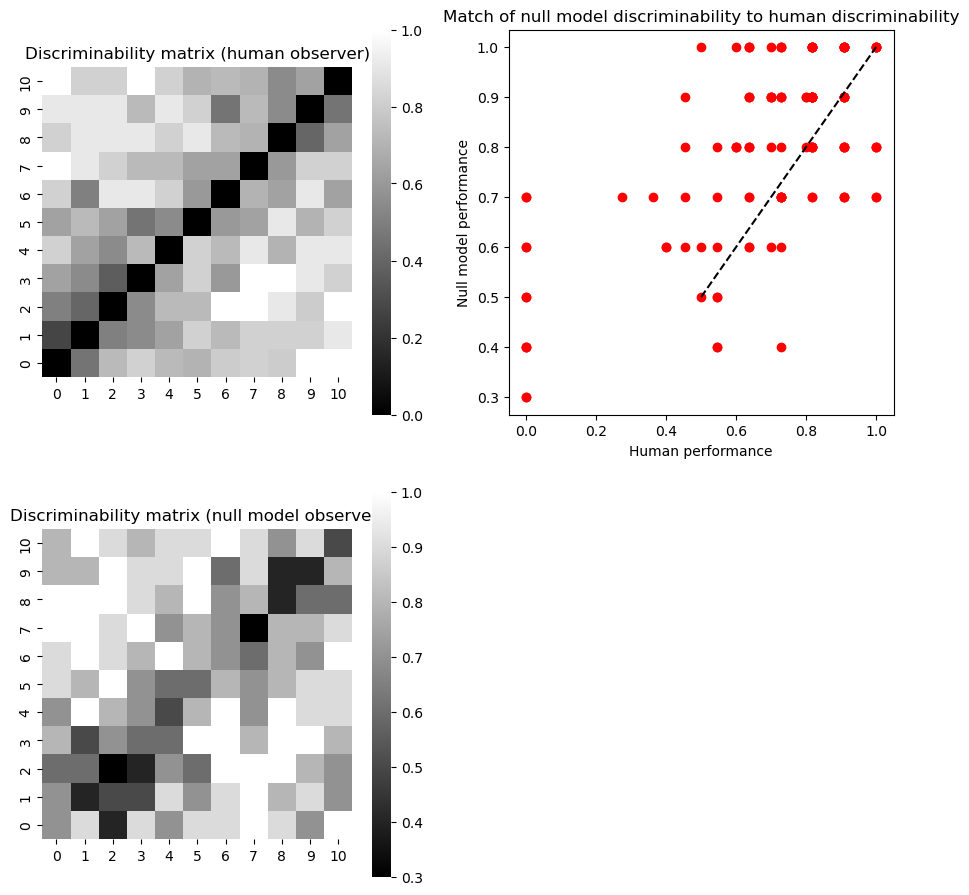

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on simulated data from null model

In [ ]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=80000)
x_null_elbo, p_null_elbo, errors_null_elbo, kl_loss_null, ll_loss_null, c_prior_null, d_prior_null, l_prior_null, _, _, _, c_est_null = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 417.55953704565763
Loss updated
Iteration 1 | Loss: 417.55953704565763
Current loss: 431.1260906383395
Iteration 2 | Loss: 431.1260906383395
Current loss: 418.45143185555935
Iteration 3 | Loss: 418.45143185555935
Current loss: 431.1520351395011
Iteration 4 | Loss: 431.1520351395011
Current loss: 432.0077670291066
Iteration 5 | Loss: 432.0077670291066
Current loss: 431.394931435585
Iteration 6 | Loss: 431.394931435585
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 7 | Loss: 422.484845161438
Current loss: 434.9927235469222
Iteration 8 | Loss: 434.9927235469222
Current loss: 434.143467977643
Iteration 9 | Loss: 434.143467977643
Current loss: 440.83805488049984
Iteration 10 | Loss: 440.83805488049984
Epoch: 0, Loss: 3188.436495862518
Epoch: 250, Loss: 1925.2499668085875
Epoch: 500, Loss: 1492.1860150723662
Epoch: 750, Loss: 1263.9327659459896
Epoch: 1000, Loss: 1117.826990835636
Epoch: 1250, Loss: 1013.7885619422827
Epoc

In [13]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

Estimated global curvature: 93.32157135009766 degrees
Average estimated local curvature: 93.32003410295829 degrees


### Run optimization on real data

In [8]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 1 | Loss: 656.3027134686708
Current loss: 642.42967492342
Loss updated
Iteration 2 | Loss: 642.42967492342
Current loss: 651.4780212491751
Iteration 3 | Loss: 651.4780212491751
Current loss: 638.9605898633599
Loss updated
Iteration 4 | Loss: 638.9605898633599
Current loss: 648.4703730940819
Iteration 5 | Loss: 648.4703730940819
Current loss: 644.2377479970455
Iteration 6 | Loss: 644.2377479970455
Current loss: 664.6692404896021
Iteration 7 | Loss: 664.6692404896021
Current loss: 677.3980708271265
Iteration 8 | Loss: 677.3980708271265
Current loss: 632.4505023509264
Loss updated
Iteration 9 | Loss: 632.4505023509264
Current loss: 646.5188889652491
Iteration 10 | Loss: 646.5188889652491
Epoch: 0, Loss: 1245.629835383147
Epoch: 250, Loss: 1117.1131474723652
Epoch: 500, Loss: 1058.5437725044324
Epoch: 750, Loss: 1015.7418973716917
Epoch: 1000, Loss: 971.9806142737539
Epoch: 1250, Loss: 93

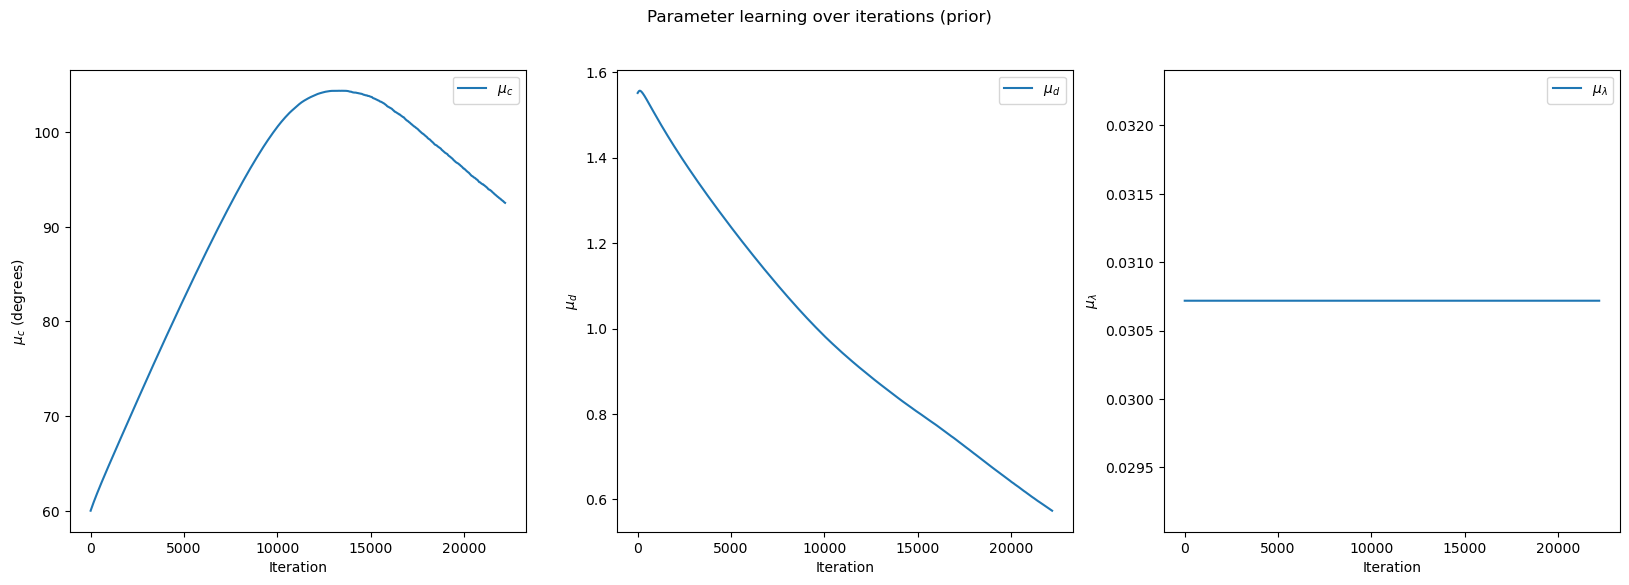

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_88928/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


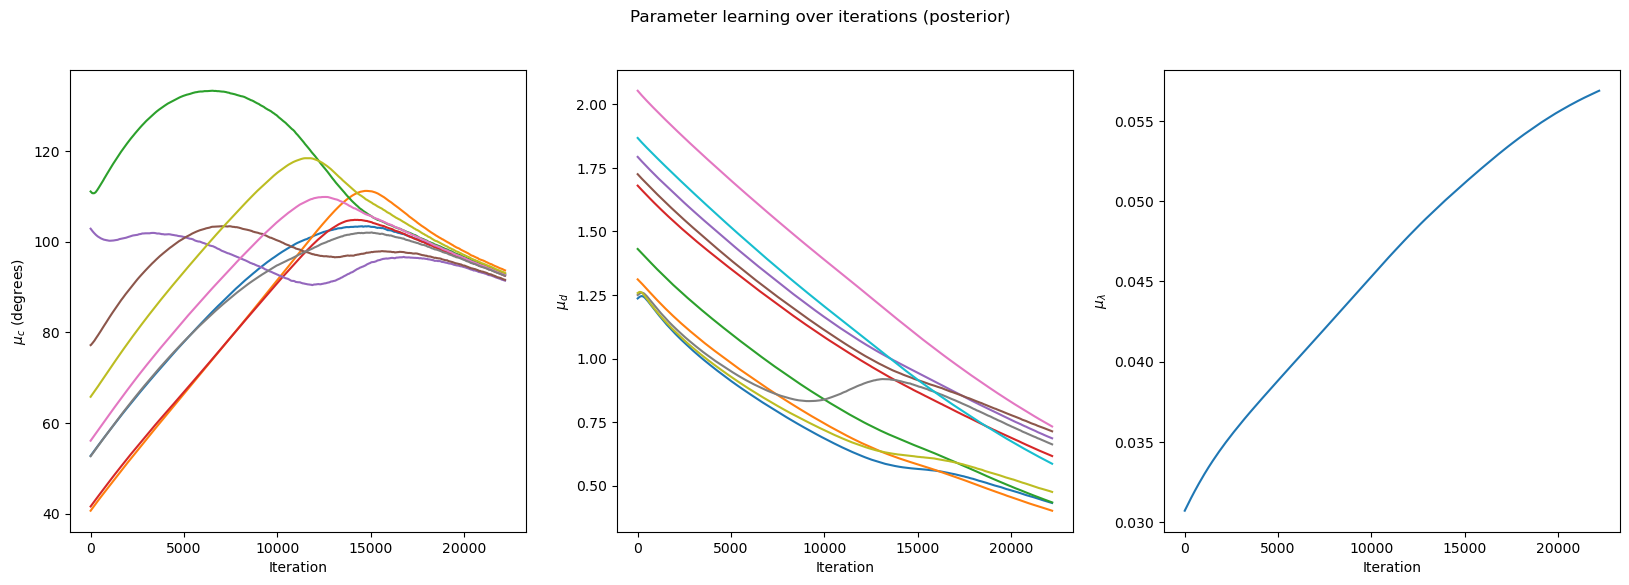

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [11]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 92.5266342163086 degrees
Average estimated local curvature: 92.52533729871026 degrees


### Analyze results

In [14]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

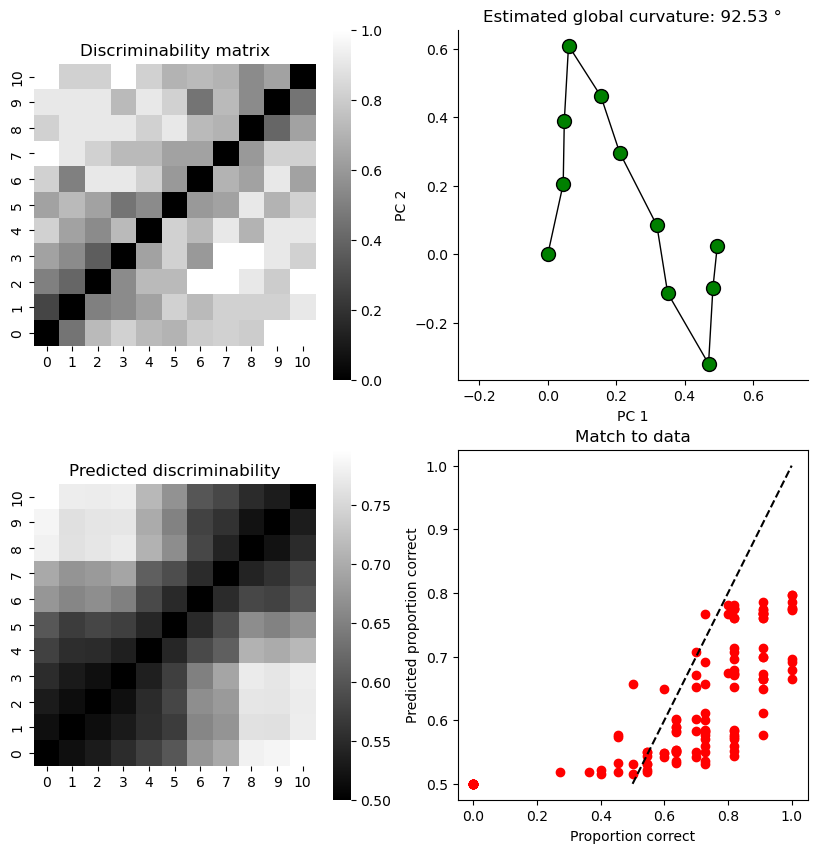

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()